## Data EDA
#### 해당 EDA 는 3_OutlierToEDA 이후 파일임
---

  1. Set data
    - Set the time stamp for heat map and scatter plot
    - Calculate Again the `"단지별 평균 월세", "단지펼 평균 보증금"` Because We use only current infomation of `"월세금(만원)), "보증금(만원)"`
      
    ---


  2. EDA
    - Seperate Data
        1. `apt_lease`
        2. `apt_rent`
        3. `officetel_lease`
        4. `officetel_rent`

    - Check the count of each categories
        - `filename: bar_plot_count_apt_office_rent_lease.png`

    - Check the count of `'단지별 평균 월세', '단지별 평균 보증금'`

    - EDA of `'단지별 평균 월세', '단지별 평균 보증금'`
        1. `apt_lease`
        2. `apt_rent`
        3. `officetel_lease`
        4. `officetel_rent`

    ---

  3. Correlation

    - APT-LEASE EDA
        - Setting
            1. Set the numeric columns
            2. Set the path to save image
        - EDA
            - `Heat map`
            - `Scatter plot (pair)`

    - OFFICE-LEASE EDA
        - EDA
            - `Heat map`
            - `Scatter plot (pair)`

    ---
    
  4. Only lease data
    - Set data(`"전월세구분"=="전세"`)
    - Transfer to `log("보증금(만원)", "단지별_평균_평균보증금")`
    - EDA each APT, OFFCETEL

  5. Save processed data
    - Drop the columns not usefull
    - Save data
        - `name: final_lease_.csv`
    
    ---

      
    

#### data load

In [4]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install koreanize-matplotlib

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
# 런타임 다시 시작 후 실행
%matplotlib inline
import matplotlib as mpl

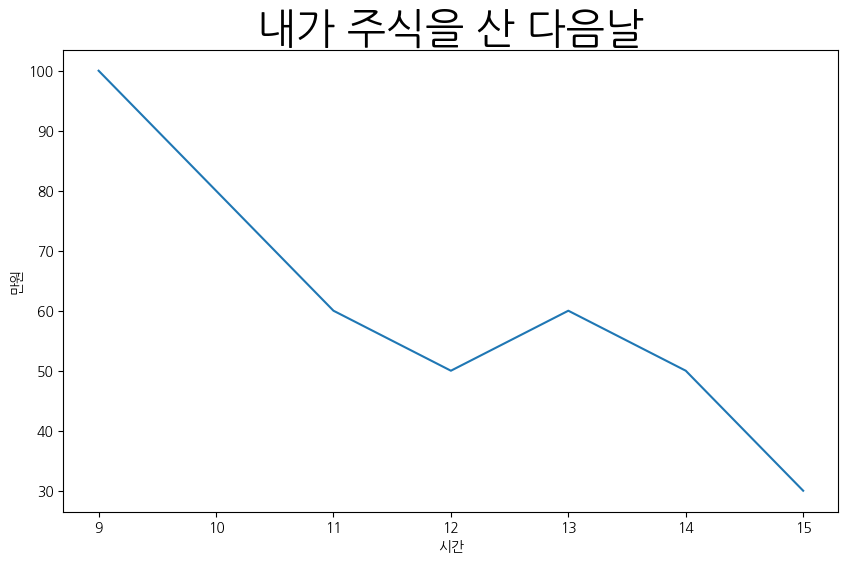

In [7]:
import koreanize_matplotlib
a = [1,2,3,4,5,6,7,8,9,10]
b = np.random.rand(10)
plt.figure(figsize=(10, 6))
plt.plot([9, 10, 11, 12, 13, 14, 15], [100, 80, 60, 50, 60, 50, 30])
plt.title('내가 주식을 산 다음날', size=30)
plt.xlabel('시간')
plt.ylabel('만원')
plt.show()

### Set data
- Set the time stamp for heat map and scatter plot
- Calculate Again the `"단지별 평균 월세", "단지펼 평균 보증금"` Because We use only current infomation of `"월세금(만원)), "보증금(만원)"`


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/predict_price/3_Rent_Lease.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,단지명,전월세구분,전용면적(㎡),보증금(만원),월세금(만원),층,건축년도,갱신요구권 사용,종전계약 보증금(만원),종전계약 월세(만원),...,계약개월수,단지별 평균 보증금,단지별 평균 월세금,계약구분_보완,is_new_contract,is_renewal,보증금 변화,월세 변화,종전계약_유무,is_rent
0,청호 서울숲 뜨레피움 오피스텔,전세,19.03,18000.0,0.0,3,2018.0,0,-1.0,-1.0,...,24,18545.588235,0.00000,신규,1,0,-1.0,-1.0,0,0
1,더클래스,전세,43.17,23000.0,0.0,4,2019.0,0,-1.0,-1.0,...,24,22627.794118,0.00000,신규,1,0,-1.0,-1.0,0,0
2,화양타워,전세,37.34,11000.0,0.0,4,1999.0,0,-1.0,-1.0,...,24,18908.888889,0.00000,신규,1,0,-1.0,-1.0,0,0
3,효성네오인텔리안,월세,31.71,1000.0,50.0,4,2005.0,0,-1.0,-1.0,...,24,655.172414,57.37931,신규,1,0,-1.0,-1.0,0,1
4,한강현대하이엘,전세,40.28,21000.0,0.0,15,2005.0,0,-1.0,-1.0,...,24,21936.083333,0.00000,신규,1,0,-1.0,-1.0,0,0


In [9]:
df['갱신요구권 사용'].value_counts()

,count
갱신요구권 사용,
0,1622164
1,128189


In [10]:
df['계약날짜'] = pd.to_datetime(df['계약날짜'])  # 계약날짜를 datetime 형식으로 변환
df['timestamp'] = df['계약날짜'].astype(int) / 10**9  # 초 단위로 변환


#### 단지별 평균단가 생성

In [11]:
import pandas as pd

def update_housing_prices(df, rent_type_col="전월세구분"):
    """
    현재 데이터 기준으로 단지별 평균 보증금 & 월세 다시 계산하여 업데이트

    Parameters:
        df (pd.DataFrame): 원본 데이터
        rent_type_col (str): 전월세 구분 컬럼명 ("계약구분")

    Returns:
        df (pd.DataFrame): 단지별 평균 보증금/월세 컬럼이 업데이트된 DataFrame
    """

    # 🔹 1. 단지별 & 전월세별 평균 보증금 & 월세 계산
    grouped = df.groupby(["단지명", rent_type_col], as_index=False).agg(
        단지별_평균_보증금=("보증금(만원)", "mean"),
        단지별_평균_월세금=("월세금(만원)", "mean")
    )

    # 🔹 2. 기존 df와 병합하여 최신 데이터 기준으로 업데이트
    updated_df = df.drop(columns=["단지별 평균 보증금", "단지별 평균 월세금"], errors="ignore")  # 기존 컬럼 제거
    updated_df = updated_df.merge(grouped, on=["단지명", rent_type_col], how="left")

    print("\n✅ 단지별 평균 보증금 & 월세를 현재 데이터 기준으로 다시 계산 완료!")

    return updated_df


In [12]:
df = update_housing_prices(df)



✅ 단지별 평균 보증금 & 월세를 현재 데이터 기준으로 다시 계산 완료!


In [13]:
for col in df.columns:
    print(f"'{col}'")


'단지명'
'전월세구분'
'전용면적(㎡)'
'보증금(만원)'
'월세금(만원)'
'층'
'건축년도'
'갱신요구권 사용'
'종전계약 보증금(만원)'
'종전계약 월세(만원)'
'주택유형'
'index'
'rate'
'pp_rate'
'전체주소'
'동'
'계약날짜'
'계약연도'
'계약월'
'계약요일'
'IMF_경과년수'
'금융위기_경과년수'
'계약개월수'
'계약구분_보완'
'is_new_contract'
'is_renewal'
'보증금 변화'
'월세 변화'
'종전계약_유무'
'is_rent'
'timestamp'
'단지별_평균_보증금'
'단지별_평균_월세금'


In [14]:

def validate_housing_prices(df, rent_type_col="전월세구분"):
    """
    현재 df의 '단지별 평균 보증금' & '단지별 평균 월세금'이 올바르게 계산되었는지 검증

    Parameters:
        df (pd.DataFrame): 단지별 평균 보증금 & 월세 컬럼이 포함된 데이터프레임
        rent_type_col (str): 전월세 구분 컬럼명 ("전월세구분")

    Returns:
        None (출력으로 검증 결과 확인)
    """

    # 🔹 1. 현재 데이터 기준으로 단지별 평균 보증금 & 월세 다시 계산
    grouped = df.groupby(["단지명", rent_type_col], as_index=False).agg(
        계산된_평균_보증금=("보증금(만원)", "mean"),
        계산된_평균_월세금=("월세금(만원)", "mean")
    )

    # 🔹 2. 기존 df와 비교하기 위해 병합
    merged_df = df.merge(grouped, on=["단지명", rent_type_col], how="left")

    # 🔹 3. 차이 계산 (절대값 기준)
    merged_df["보증금_차이"] = (merged_df["단지별_평균_보증금"] - merged_df["계산된_평균_보증금"]).abs()
    merged_df["월세금_차이"] = (merged_df["단지별_평균_월세금"] - merged_df["계산된_평균_월세금"]).abs()

    # 🔹 4. 차이가 있는 경우 출력
    diff_df = merged_df[(merged_df["보증금_차이"] > 1e-5) | (merged_df["월세금_차이"] > 1e-5)]

    if diff_df.empty:
        print("\n✅ 단지별 평균 보증금 & 월세 계산이 올바르게 되어 있습니다!")
    else:
        print("\n⚠️ 단지별 평균 보증금 & 월세 계산 오류 발견!")
        print(diff_df[["단지명", rent_type_col, "단지별 평균 보증금", "계산된_평균_보증금",
                        "단지별 평균 월세금", "계산된_평균_월세금", "보증금_차이", "월세금_차이"]])



In [15]:
validate_housing_prices(df)



✅ 단지별 평균 보증금 & 월세 계산이 올바르게 되어 있습니다!


In [16]:
# 컬럼 이름 정리
df = df.rename(columns={
    "전용면적(㎡)": "전용면적m",
    "보증금(만원)": "보증금만원",
    "월세금(만원)": "월세금만원",
    "갱신요구권 사용": "갱신요구권사용(2진)",
    "종전계약 보증금(만원)": "종전계약보증금만원",
    "종전계약 월세(만원)": "종전계약월세금만원",
    "IMF_경과년수": "IMF경과년수",
    "금융위기_경과년수": "금융위기경과년수",
    "계약구분_보완": "계약구분보완(범주)",
    "보증금 변화": "보증금변화만원",
    "월세 변화": "월세변화만원",
    "종전계약_유무": "종전계약유무(2진)",
    "단지별_평균_보증금": "단지별평균보증금만원",
    "단지별_평균_월세금": "단지별평균월세금만원",
    "is_new_contract": "IsNewContract(2진)",
    "is_renewal": "IsRenewal(2진)",
    "is_rent": "IsRent(2진)",
    "timestamp": "Timestamp",
    "pp_rate": "PpRate",
    "rate": "Rate",
    "index": "Index"  # 쉼표 수정
})


### EDA
- Seperate Data
    1. `apt_lease`
    2. `apt_rent`
    3. `officetel_lease`
    4. `officetel_rent`

- Check the count of each categories
    - `filename: bar_plot_count_apt_office_rent_lease.png`

- Check the count of `'단지별 평균 월세', '단지별 평균 보증금'`

- EDA of `'단지별 평균 월세', '단지별 평균 보증금'`
    1. `apt_lease`
    2. `apt_rent`
    3. `officetel_lease`
    4. `officetel_rent`
    


#### Seperate Data

In [17]:
# 주택 유형과 전월세 구분 기준으로 데이터 나누기
apt_lease = df[(df['주택유형'] == '아파트') & (df['전월세구분'] == '전세')]
apt_rent = df[(df['주택유형'] == '아파트') & (df['전월세구분'] == '월세')]

officetel_lease = df[(df['주택유형'] == '오피스텔') & (df['전월세구분'] == '전세')]
officetel_rent = df[(df['주택유형'] == '오피스텔') & (df['전월세구분'] == '월세')]
office = df[df['주택유형'] == '오피스텔']

apt_lease = apt_lease.reset_index(drop=True)
apt_rent = apt_rent.reset_index(drop=True)

officetel_lease = officetel_lease.reset_index(drop=True)
officetel_rent = officetel_rent.reset_index(drop=True)
office = office.reset_index(drop=True)

# 불필요한 컬럼 삭제
apt_lease = apt_lease.drop(columns=['단지별평균월세금만원', "월세금만원", "종전계약월세금만원", "월세변화만원"])
officetel_lease = officetel_lease.drop(columns=['단지별평균월세금만원', "월세금만원", "종전계약월세금만원", "월세변화만원"])

# 데이터 개수 확인
print(f"아파트 전세: {len(apt_lease)}개")
print(f"아파트 월세: {len(apt_rent)}개")
print(f"오피스텔 전세: {len(officetel_lease)}개")
print(f"오피스텔 월세: {len(officetel_rent)}개")
print(f"오피스텔: {len(office)}개")


아파트 전세: 868655개
아파트 월세: 522654개
오피스텔 전세: 156276개
오피스텔 월세: 202768개
오피스텔: 359044개


####  Check the count of each categories

- `filename: bar_plot_count_apt_office_rent_lease.png`

#### Check the count of `'단지별 평균 월세', '단지별 평균 보증금'`

- EDA of `'단지별 평균 월세', '단지별 평균 보증금'`
    1. `apt_lease`
    2. `apt_rent`
    3. `officetel_lease`
    4. `officetel_rent`

#### Check the distribution


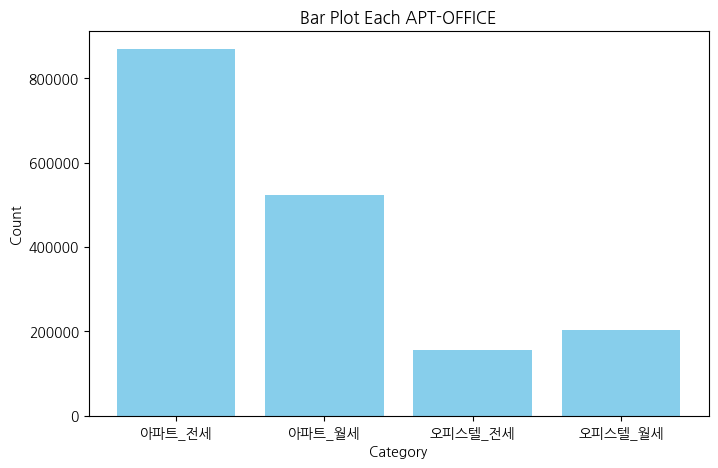

In [21]:
###
categories = ["아파트_전세", "아파트_월세", "오피스텔_전세", "오피스텔_월세"]
values = [len(apt_lease), len(apt_rent), len(officetel_lease), len(officetel_rent)]

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color='skyblue')  # 세로 바 플롯
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Bar Plot Each APT-OFFICE')
plt.savefig("bar_plot_count_apt_office_rent_lease.png", dpi = 300)
plt.show()

In [18]:
df['단지갯수'] = df.groupby('단지명')['단지명'].transform('size')

print((df.loc[(df['주택유형'] == "아파트") & (df["전월세구분"] == "전세"), '단지갯수'] > 500).astype(int).sum()
        ,(df.loc[(df['주택유형'] == "오피스텔") & (df["전월세구분"] == "전세"), '단지갯수'] > 100).astype(int).sum())



554015 111521


In [19]:
df.loc[(df['주택유형'] == "아파트") & (df["전월세구분"] == "전세"), '단지갯수']
df.loc[(df['주택유형'] == "오피스텔") & (df["전월세구분"] == "전세"), '단지갯수']

,단지갯수
0,40
1,167
2,118
4,131
5,100
...,...
359022,92
359023,50
359029,2171
359032,299


In [20]:
office['전월세구분'].value_counts()

,count
전월세구분,
월세,202768
전세,156276


In [21]:
officetel_lease['전월세구분'].value_counts()

,count
전월세구분,
전세,156276


In [ ]:
# save_path = "/content/drive/MyDrive/Colab Notebooks/predict_price/EDA/"

In [ ]:
# save_path1 = "/content/drive/MyDrive/Colab Notebooks/predict_price/EDA/APTR"
# save_path2 = "/content/drive/MyDrive/Colab Notebooks/predict_price/EDA/APTL"
# save_path3 = "/content/drive/MyDrive/Colab Notebooks/predict_price/EDA/OPL"
# save_path4 = "/content/drive/MyDrive/Colab Notebooks/predict_price/EDA/OPR"


#### PLOT_HOUSING_DATA Function1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_housing_data(df, save_path=None):
    # 단지별 평균 보증금과 월세금 계산
    df['단지갯수'] = df.groupby('단지명')['단지명'].transform('size')

    # 월세 or 전세 데이터 필터링
    is_rent = df['IsRent'].iloc[0]  # 월세(1) or 전세(0) 확인

    # 12개 상위 데이터 추출
    if is_rent == 1:  # 월세일 때
        # 단지별 평균 보증금, 월세금 계산
        top_12 = df.groupby('단지명').agg({'단지별평균보증금만원': 'mean', '단지별평균월세금만원': 'mean', '단지갯수': 'max'})

        # 단지갯수 필터링 (아파트 1000개 이상, 오피스텔 100개 이상)
        top_12 = top_12[(top_12['단지갯수'] >= 1000) if '아파트' in df['단지명'].iloc[0] else (top_12['단지갯수'] >= 100)]

        # 상위 12개 월세 단지
        top_12_monthly = top_12.nlargest(12, '단지별평균월세금만원')

        # 단지별 평균 보증금, 월세금 막대그래프
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x=top_12_monthly.index, y=top_12_monthly['단지별평균월세금만원'], color='orange')
        plt.title("상위 12개 월세 단지별 평균 월세금")
        plt.xlabel('단지명')
        plt.ylabel('단지별 평균 월세금 (만원)')
        plt.xticks(rotation=45)

        # 막대 위에 해당 단지의 개수 표시
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f'{int(p.get_height())+1}',
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold', verticalalignment='bottom')

        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/top_12_monthly_rent.png")  # 그래프 저장
        plt.show()

        # 단지별 평균 보증금, 월세금 막대그래프
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x=top_12_monthly.index, y=top_12_monthly['단지별평균보증금만원'], color='blue')
        plt.title("상위 12개 월세 단지별 평균 보증금")
        plt.xlabel('단지명')
        plt.ylabel('단지별 평균 보증금 (만원)')
        plt.xticks(rotation=45)

        # 막대 위에 해당 단지의 개수 표시
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f'{int(p.get_height())+1}',
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold', verticalalignment='bottom')

        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/top_12_monthly_deposit.png")  # 그래프 저장
        plt.show()

        # 단지갯수와 단지별 평균 보증금, 월세금의 관계 산점도
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=df, x="단지갯수", y="단지별평균월세금만원", color='orange', label='단지별 평균 월세금')
        plt.title("단지 개수 vs 단지별 평균 월세금")
        plt.xlabel('단지 개수')
        plt.ylabel('단지별 평균 월세금 (만원)')
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/scatter_danji_count_vs_rent.png")  # 그래프 저장
        plt.show()

        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=df, x="단지갯수", y="단지별평균보증금만원", color='blue', label='단지별 평균 보증금')
        plt.title("단지 개수 vs 단지별 평균 보증금")
        plt.xlabel('단지 개수')
        plt.ylabel('단지별 평균 보증금 (만원)')
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/scatter_danji_count_vs_deposit.png")  # 그래프 저장
        plt.show()

        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=df, x="단지별_평균_보증금", y="단지별평균월세금만원", color='green', label='보증금 vs 월세금')
        plt.title("단지별 평균 보증금 vs 월세금")
        plt.xlabel('단지별 평균 보증금 (만원)')
        plt.ylabel('단지별 평균 월세금 (만원)')
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/scatter_deposit_vs_rent.png")  # 그래프 저장
        plt.show()

    else:  # 전세일 때
        # 단지별 평균 보증금 계산
        top_12 = df.groupby('단지명').agg({'단지별평균보증금만원': 'mean', '단지갯수': 'max'})

        # 단지갯수 필터링 (아파트 1000개 이상, 오피스텔 100개 이상)
        top_12 = top_12[(top_12['단지갯수'] >= 1000) if '아파트' in df['단지명'].iloc[0] else (top_12['단지갯수'] >= 100)]

        # 상위 12개 전세 단지
        top_12_lease = top_12.nlargest(12, '단지별평균보증금만원')

        # 단지별 평균 보증금 막대그래프
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x=top_12_lease.index, y=top_12_lease['단지별평균보증금만원'], color='blue')
        plt.title("상위 12개 전세 단지별 평균 보증금")
        plt.xlabel('단지명')
        plt.ylabel('단지별 평균 보증금 (만원)')
        plt.xticks(rotation=45)

        # 막대 위에 해당 단지의 개수 표시
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f'{int(p.get_height())}',
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold', verticalalignment='bottom')

        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/top_12_lease_deposit.png")  # 그래프 저장
        plt.show()

        # 단지갯수와 단지별 평균 보증금의 관계 산점도
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=df, x="단지갯수", y="단지별평균보증금만원", color='blue', label='단지별 평균 보증금')
        plt.title("단지 개수 vs 단지별 평균 보증금")
        plt.xlabel('단지 개수')
        plt.ylabel('단지별 평균 보증금 (만원)')
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/scatter_danji_count_vs_lease_deposit.png")  # 그래프 저장
        plt.show()


In [ ]:
plot_housing_data(apt_lease, save_path2 )
plot_housing_data(apt_rent, save_path1)
plot_housing_data(officetel_lease, save_path3)
plot_housing_data(officetel_rent, save_path4)



#### HOUSING PLOT 2

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_housing_data2(df, save_path=None):
    # 단지별 평균 보증금 계산
    df['단지별평균보증금만원'] = df.groupby('단지명')['보증금만원'].transform('mean')
    df['단지갯수'] = df.groupby('단지명')['단지명'].transform('size')

    # 주택 유형 확인
    house = df['주택유형'].iloc[0]

    # 아파트는 단지 개수 500개 이상, 오피스텔은 100개 이상 필터링 후 상위 12개 선정
    if house == '아파트':
        filtered_df = df[df['단지갯수'] >= 500]
    else:  # 오피스텔
        filtered_df = df[df['단지갯수'] >= 100]

    top_12 = filtered_df.groupby('단지명').agg({'단지별평균보증금만원': 'mean', '단지갯수': 'first'})
    top_12 = top_12.nlargest(12, '단지별평균보증금만원')

    # 단지별 평균 보증금 막대그래프
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("coolwarm", len(top_12))  # 색상 조정

    ax = sns.barplot(x=top_12.index, y=top_12['단지별평균보증금만원'], palette=colors)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # x축 레이블 회전

    plt.title(f"{house} 상위 12개 전세 단지별 평균 보증금")
    plt.xlabel('순위')
    plt.ylabel('단지별 평균 보증금 (만원)')

    # 막대 위에 해당 단지의 개수 표시
    for p, count in zip(ax.patches, top_12['단지갯수']):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + (p.get_height() * 0.02),
                f'{int(count)}', ha='center', va='bottom', fontsize=10,
                color='black', fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}/{house}_top_12_lease_deposit.png")  # 그래프 저장
    plt.show()

    # 단지 개수와 단지별 평균 보증금의 관계 산점도
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x="단지갯수", y="단지별평균보증금만원", color='blue', label='단지별 평균 보증금')
    plt.title(f"{house} 단지 개수 vs 단지별 평균 보증금")
    plt.xlabel('단지 개수')
    plt.ylabel('단지별 평균 보증금 (만원)')
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}/{house}_scatter_danji_count_vs_lease_deposit.png")  # 그래프 저장
    plt.show()

<ipython-input-32-64322e827b73>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_12.index, y=top_12['단지별평균보증금만원'], palette=colors)
<ipython-input-32-64322e827b73>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # x축 레이블 회전


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/predict_price/EDAAfterOutlier/아파트_top_12_lease_deposit.png'

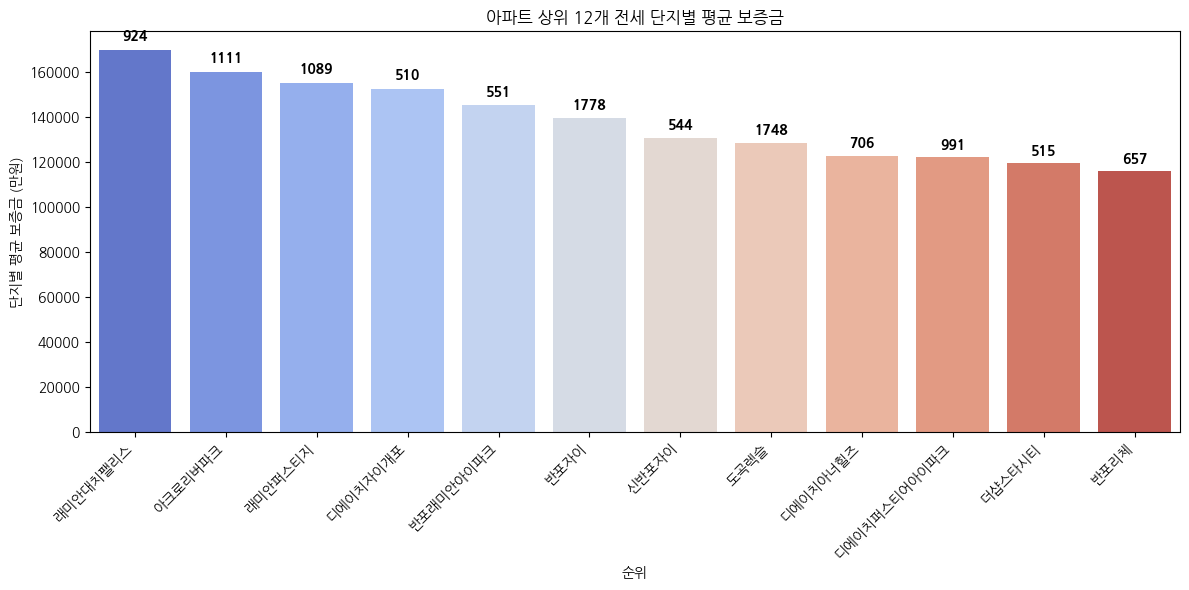

In [33]:
save_path = '/content/drive/MyDrive/Colab Notebooks/predict_price/'
plot_housing_data2(apt_lease, save_path=save_path)
plot_housing_data2(officetel_lease, save_path=save_path)

#### Check the distribution

In [ ]:
#
import matplotlib.pyplot as plt
import seaborn as sns

def plot_deposit_distribution(df, save_path = None):
    """
    전세 데이터에 대해 주택유형별 보증금(만원)의 밀도 분포를 그리고 저장하는 함수
    df: pandas DataFrame
    """
    lease_df = df[df['전월세구분'] == '전세']  # 전세 데이터만 선택
    housing_types = lease_df['주택유형'].unique()  # 주택유형 리스트 가져오기

    for housing_type in housing_types:
        subset = lease_df[lease_df['주택유형'] == housing_type]  # 특정 주택유형 데이터 필터링

        # 데이터 개수 출력
        num_samples = len(subset)
        print(f"{housing_type} 전세 데이터 개수: {num_samples}개")

        # 밀도 분포 그래프 그리기
        plt.figure(figsize=(8, 5))
        sns.kdeplot(subset['보증금(만원)'], fill=True, color='blue', alpha=0.6)
        plt.xlabel('보증금(만원)')
        plt.ylabel('밀도')
        plt.title(f"{housing_type} 전세 보증금 분포")

        # 그래프 저장
        filename = f"{housing_type}_전세_dist.png"
        plt.savefig(f"{save_path+filename}", dpi=300)
        print(f"✅ 저장 완료: {filename}")
        plt.close()  # 그래프 닫기

    rent_df = df[df['전월세구분'] == '월세']  # 전세 데이터만 선택

    for housing_type in housing_types:
        subset = rent_df[rent_df['주택유형'] == housing_type]  # 특정 주택유형 데이터 필터링

        # 데이터 개수 출력
        num_samples = len(subset)
        print(f"{housing_type} 월세 데이터 개수: {num_samples}개")

        # 밀도 분포 그래프 그리기
        plt.figure(figsize=(8, 5))
        sns.kdeplot(subset['보증금(만원)'], fill=True, color='blue', alpha=0.6)
        sns.kdeplot(subset['월세금(만원)'], fill=True, color='orange', alpha=0.6)
        plt.xlabel('보증금(만원)-월세금(만원')
        plt.ylabel('밀도')
        plt.title(f"{housing_type} 전세 보증금 분포")

        # 그래프 저장
        filename = f"{housing_type}_월세_dist.png"
        plt.savefig(f"{save_path+filename}", dpi=300)
        print(f"✅ 저장 완료: {filename}")
        plt.close()  # 그래프 닫기




In [ ]:
# 함수 실행
save_path5 = "/content/drive/MyDrive/Colab Notebooks/predict_price/EDA/"
plot_deposit_distribution(df,save_path5)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 밀도 분포 그래프 그리기
plt.figure(figsize=(8, 5))

# 아파트 보증금 밀도 그래프
sns.kdeplot(df.loc[df['주택유형'] == "아파트", '보증금(만원)'], fill=True, color='blue', alpha=0.3, label="아파트")

# 오피스텔 보증금 밀도 그래프
sns.kdeplot(df.loc[df['주택유형'] == "오피스텔", '보증금(만원)'], fill=True, color='red', alpha=0.3, label="오피스텔")

plt.xlabel('보증금(만원)')
plt.ylabel('밀도')
plt.title("전세 보증금 분포")
plt.legend()  # 범례 추가
plt.savefig(f"{save_path5}전세가 분포.png", dpi = 300)
plt.show()


In [ ]:
df.columns

#### EDA After Outlier

### Correlation

#### APT-LEASE EDA
- Setting
    1. Set the numeric columns
    2. Set the path to save image
- EDA
    - `Heat map`
    - `Scatter plot (pair)`

#### OFFICE-LEASE EDA
- EDA
    - `Heat map`
    - `Scatter plot (pair)`

In [23]:
# EDA 코드

def distribution_plot(df, numeric_columns, save_path = None):
    """
    전세/월세별 수치형 변수의 분포를 선 그래프로 시각화하는 함수
    df: pandas DataFrame
    numeric_columns: 수치형 데이터 컬럼 목록
    housing_type: 분석할 주택유형 (기본값은 None으로 전체 데이터 분석)
    """

    # 주택 유형별 필터링
    housing_type = df["주택유형"].iloc[2]
    rent = df['전월세구분'].iloc[0]


    plt.figure(figsize=(12, len(numeric_columns) * 3))  # 가변적인 크기 설정

    for i, col in enumerate(numeric_columns, 1):
        plt.subplot(len(numeric_columns), 1, i)  # 여러 개의 그래프 배치

        # 전세 (파란색) - 선 그래프
        sns.kdeplot(df[col], label=f"전세 {col}", color='blue', linewidth=2)

        plt.title(f"{col} 분포 ({housing_type if housing_type else '전체'})")
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_path}Distribution_{housing_type}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 3. 히트맵 (상관행렬)
def heat_map(df, numeric_columns, save_path = None):
    """
    df param: pandas DataFrame
    numeric_columns param: list of numeric columns
    is_rent param: 월세 여부 (1이면 월세, 0이면 전세)
    housing_type param: 주택유형 (None이면 전체)
    """
    # 월세유무와 주택유형을 인자로 받아 필터링

    housing_type = df["주택유형"].iloc[2]
    rent = df['전월세구분'].iloc[0]


    corr_matrix = df[numeric_columns].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'{housing_type}-{rent}상관행렬 히트맵')
    plt.savefig(f"{save_path}{rent}-{housing_type}_ScatterMatrix.png", dpi=300, bbox_inches='tight')
    plt.show()
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

def scatter_plot(df, numeric_columns, save_path=None):
    """
    df param: pandas DataFrame
    numeric_columns param: list of numeric columns
    save_path param: Save directory path (str)
    """
    # 주택유형 & 전월세구분 가져오기
    housing_type = df["주택유형"].iloc[2]
    rent = df["전월세구분"].iloc[0]

    # Pairplot 생성 (is_rent 없이)
    pairplot = sns.pairplot(df[numeric_columns],
                             diag_kind="kde",
                             diag_kws={"fill": True, "alpha": 0.5},  # 밀도 색상 투명도 추가
                             plot_kws={"s": 5, "alpha": 0.7})  # 점 크기 & 투명도 조정

    # 화질 개선
    pairplot.fig.set_dpi(500)  # DPI 높이기
    pairplot.fig.set_size_inches(15, 10)  # 크기 조정

    # 저장 경로 처리
    if save_path:
        os.makedirs(save_path, exist_ok=True)  # 폴더 자동 생성
        filename = f"{rent}-{housing_type}_ScatterMatrix.png"
        filepath = os.path.join(save_path, filename)
        pairplot.savefig(filepath, dpi=500, bbox_inches="tight")  # 고화질 저장

    plt.show()

In [46]:
apt_rent.columns

Index(['단지명', '전월세구분', '전용면적m', '보증금만원', '월세금만원', '층', '건축년도', '갱신요구권사용(2진)',
       '종전계약보증금만원', '종전계약월세금만원', '주택유형', 'Index', 'Rate', 'PpRate', '전체주소',
       '동', '계약날짜', '계약연도', '계약월', '계약요일', 'IMF경과년수', '금융위기경과년수', '계약개월수',
       '계약구분보완(범주)', 'IsNewContract(2진)', 'IsRenewal(2진)', '보증금변화만원', '월세변화만원',
       '종전계약유무(2진)', 'IsRent(2진)', 'Timestamp', '단지별평균보증금만원', '단지별평균월세금만원'],
      dtype='object')

#### APT-LEASE EDA
- Setting
    1. Set the numeric columns
    2. Set the path to save image
- EDA

In [24]:
df.columns

Index(['단지명', '전월세구분', '전용면적m', '보증금만원', '월세금만원', '층', '건축년도', '갱신요구권사용(2진)',
       '종전계약보증금만원', '종전계약월세금만원', '주택유형', 'Index', 'Rate', 'PpRate', '전체주소',
       '동', '계약날짜', '계약연도', '계약월', '계약요일', 'IMF경과년수', '금융위기경과년수', '계약개월수',
       '계약구분보완(범주)', 'IsNewContract(2진)', 'IsRenewal(2진)', '보증금변화만원', '월세변화만원',
       '종전계약유무(2진)', 'IsRent(2진)', 'Timestamp', '단지별평균보증금만원', '단지별평균월세금만원',
       '단지갯수'],
      dtype='object')

In [25]:
officetel_lease = df[(df['주택유형'] == '오피스텔') & (df['전월세구분'] == '전세')]
apt_lease = df[(df['주택유형'] == '아파트') & (df['전월세구분'] == '전세')]

In [26]:
list(df.columns) == list(apt_lease.columns)

True

In [27]:
col = list(df.columns)
lease_col = []

In [28]:
for i in col:
  if '월세' in i:
    continue
  else:
    lease_col.append(i)

In [29]:
lease_col

['단지명',
 '전용면적m',
 '보증금만원',
 '층',
 '건축년도',
 '갱신요구권사용(2진)',
 '종전계약보증금만원',
 '주택유형',
 'Index',
 'Rate',
 'PpRate',
 '전체주소',
 '동',
 '계약날짜',
 '계약연도',
 '계약월',
 '계약요일',
 'IMF경과년수',
 '금융위기경과년수',
 '계약개월수',
 '계약구분보완(범주)',
 'IsNewContract(2진)',
 'IsRenewal(2진)',
 '보증금변화만원',
 '종전계약유무(2진)',
 'IsRent(2진)',
 'Timestamp',
 '단지별평균보증금만원',
 '단지갯수']

In [30]:
apt_lease = apt_lease[lease_col]
officetel_lease = officetel_lease[lease_col]

In [62]:
 # heat_map()
 # scatter_plot()
 # distribution()
numeric_columns_rent = ['전용면적m', '건축년도','층','보증금만원', '월세금만원','종전계약보증금만원', '종전계약월세만원', 'Index', 'Rate','PpRate' ,'보증금변화만원', '월세변화만원', "Timestamp"]
numeric_columns_lease = ['전용면적m', '건축년도','층','보증금만원','종전계약보증금만원', 'Index', 'Rate','PpRate' ,'보증금변화만원','Timestamp']



In [52]:
save_path6 = "/content/drive/MyDrive/Colab Notebooks/predict_price/EDA/corr/"


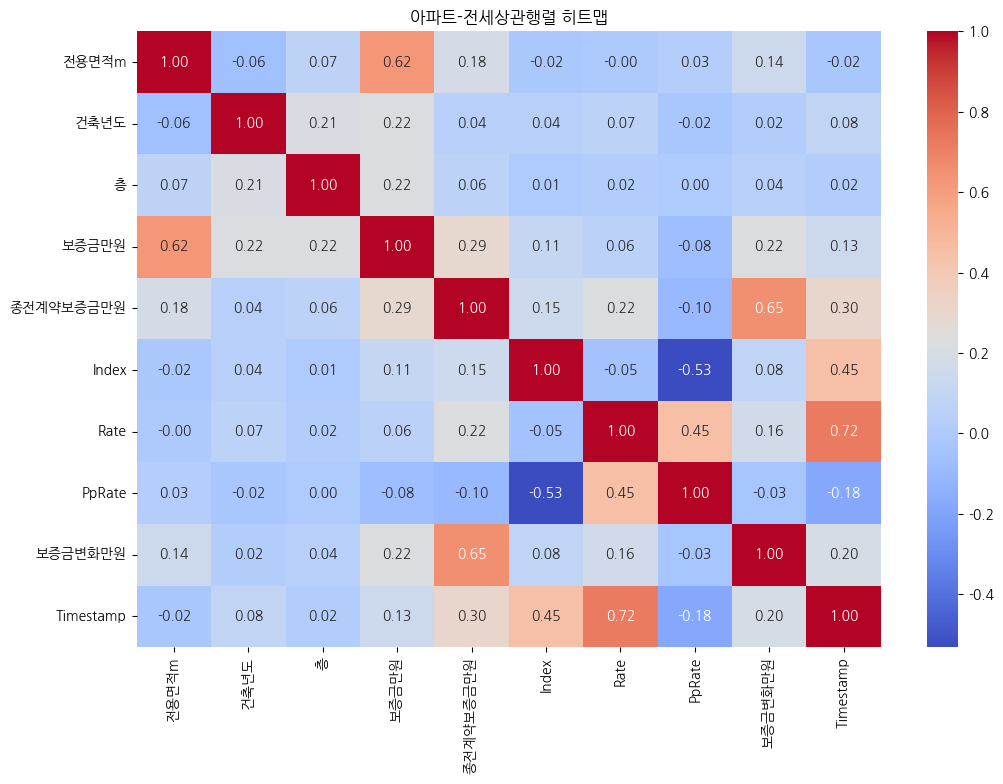

In [53]:
heat_map(apt_lease, numeric_columns_lease, save_path= save_path6)

In [43]:
apt_lease_sam = apt_lease.sample(n=10000, random_state=42)  # 1만 개 샘플링



In [54]:
scatter_plot(apt_lease_sam, numeric_columns_lease, save_path= save_path6)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# distribution_plot(apt_lease, numeric_columns_lease, save_path= save_path6)

#### 오피스텔-전세

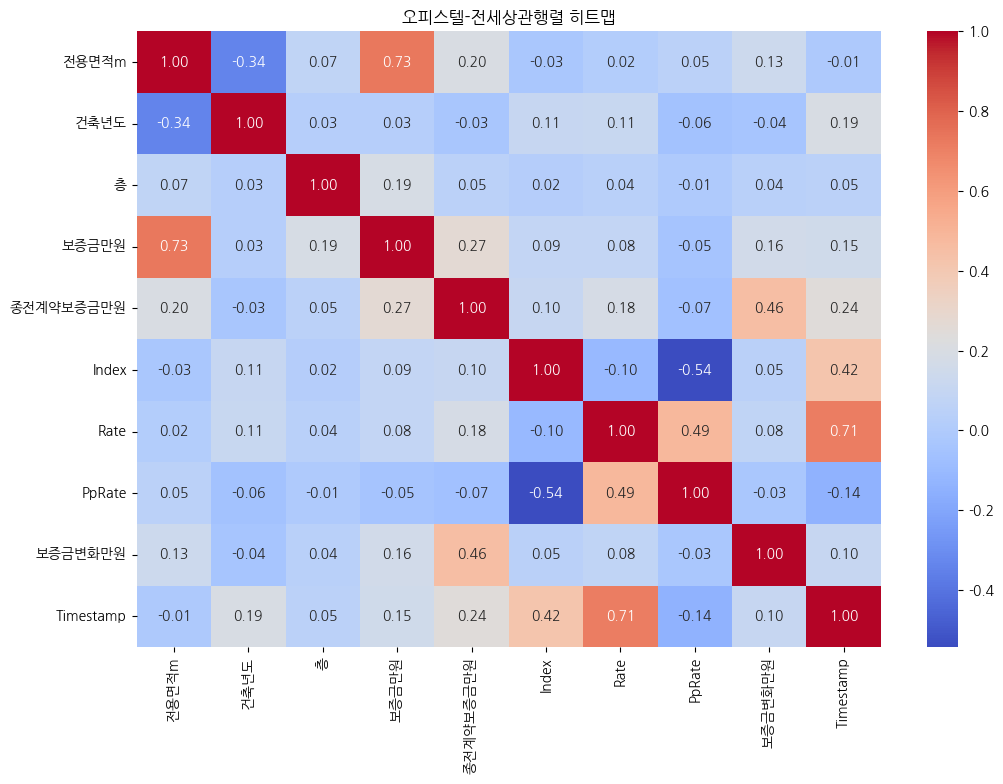

In [55]:
heat_map(officetel_lease, numeric_columns_lease, save_path= save_path6)

In [56]:
# distribution_plot(officetel_lease, numeric_columns_lease, save_path= save_path6)

In [57]:
officetel_lease_sam = officetel_lease.sample(n=10000, random_state=42)  # 1만 개 샘플링


In [ ]:
scatter_plot(officetel_lease_sam, numeric_columns_lease, save_path= save_path6)

### Only lease data
- Set data
- Transfer to log(`"보증금만원", "단지별평균보증금만원"`)
- EDA each APT, OFFCETEL

In [135]:
lease_df = pd.concat([apt_lease, officetel_lease], ignore_index=True)

In [136]:
lease_df.head()

,단지명,전월세구분,전용면적m,보증금만원,층,건축년도,갱신요구권사용(2진),종전계약보증금만원,주택유형,Index,...,계약개월수,계약구분보완(범주),IsNewContract(2진),IsRenewal(2진),보증금변화만원,종전계약유무(2진),IsRent(2진),Timestamp,단지별평균보증금만원,단지갯수
0,대성유니드,전세,59.7000,38000.0,18,2004.0,0,-1.0,아파트,2203.59,...,24,신규,1,0,-1.0,0,0,1.556582e+09,53752.296588,494
1,행당한진타운,전세,84.7100,51500.0,12,2000.0,0,-1.0,아파트,2203.59,...,24,신규,1,0,-1.0,0,0,1.556582e+09,54107.646751,1960
2,대림e-편한세상,전세,84.8700,47000.0,2,2000.0,0,-1.0,아파트,2203.59,...,24,신규,1,0,-1.0,0,0,1.556582e+09,49621.343129,3281
3,경희궁자이(2단지),전세,84.6140,70000.0,8,2017.0,0,-1.0,아파트,2203.59,...,24,신규,1,0,-1.0,0,0,1.556582e+09,93082.987887,1240
4,한남아이파크애비뉴,전세,48.7897,46000.0,5,2017.0,0,-1.0,아파트,2203.59,...,24,신규,1,0,-1.0,0,0,1.556582e+09,57191.568528,429


In [143]:
a = sorted(lease_df['동'].unique())  # 한 줄로 정렬까지 끝내기
print(a)


['가락동', '가리봉동', '가산동', '가양동', '갈월동', '갈현동', '강일동', '개봉동', '개포동', '거여동', '견지동', '경운동', '고덕동', '고척동', '공덕동', '공릉동', '공항동', '관수동', '관철동', '광장동', '광희동1가', '광희동2가', '교남동', '교북동', '구기동', '구로동', '구산동', '구수동', '구의동', '군자동', '궁동', '금호동1가', '금호동2가', '금호동3가', '금호동4가', '길동', '길음동', '낙원동', '남가좌동', '남대문로5가', '남산동2가', '남창동', '남현동', '내곡동', '내발산동', '내수동', '냉천동', '노고산동', '노량진동', '녹번동', '논현동', '누상동', '능동', '답십리동', '당산동', '당산동1가', '당산동2가', '당산동3가', '당산동4가', '당산동5가', '당산동6가', '당주동', '대림동', '대방동', '대신동', '대조동', '대치동', '대현동', '대흥동', '도곡동', '도림동', '도봉동', '도선동', '도원동', '도화동', '독산동', '돈암동', '돈의동', '동교동', '동빙고동', '동선동1가', '동선동3가', '동선동4가', '동선동5가', '동소문동4가', '동소문동5가', '동소문동6가', '동소문동7가', '동숭동', '동자동', '동작동', '둔촌동', '등촌동', '마곡동', '마장동', '마천동', '마포동', '만리동1가', '만리동2가', '망우동', '망원동', '면목동', '명륜1가', '명륜2가', '명륜3가', '명일동', '목동', '무악동', '무학동', '묵동', '묵정동', '문래동1가', '문래동2가', '문래동3가', '문래동4가', '문래동5가', '문래동6가', '문배동', '문정동', '미근동', '미아동', '반포동', '방배동', '방이동', '방학동', '방화동', '번동', '보광동', '보문동1가', '보문동2가', '보문동3가', '보문동4가'

In [144]:
lease_df = lease_df.drop(columns=['동'])

In [145]:
lease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024931 entries, 0 to 1024930
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   단지명                1024931 non-null  object        
 1   전월세구분              1024931 non-null  object        
 2   전용면적m              1024931 non-null  float64       
 3   보증금만원              1024931 non-null  float64       
 4   층                  1024931 non-null  int64         
 5   건축년도               1024931 non-null  float64       
 6   갱신요구권사용(2진)        1024931 non-null  int64         
 7   종전계약보증금만원          1024931 non-null  float64       
 8   주택유형               1024931 non-null  object        
 9   Index              1024931 non-null  float64       
 10  Rate               1024931 non-null  float64       
 11  PpRate             1024931 non-null  float64       
 12  전체주소               1024931 non-null  object        
 13  계약날짜               1024931 

In [146]:
lease_df.loc[lease_df['계약날짜']=="2024-05-01", 'Index']

,Index
868107,2636.52
868108,2636.52
868109,2636.52
868110,2636.52
868111,2636.52
...,...
1024926,2636.52
1024927,2636.52
1024928,2636.52
1024929,2636.52


In [147]:
lease_df['단지별평균보증금log'] = np.log1p(lease_df['단지별평균보증금만원'])  # log(1 + x) 변환
lease_df['보증금log'] = np.log1p(lease_df['보증금만원'])  # log(1 + x) 변환

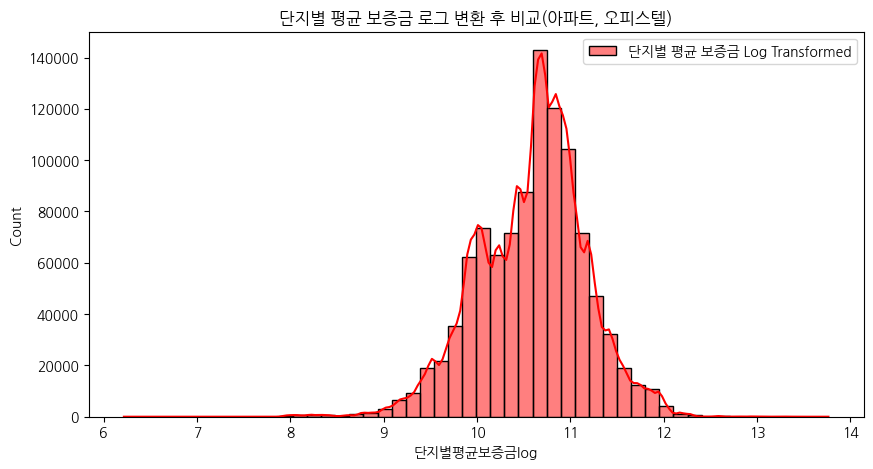

In [148]:
plt.figure(figsize=(10,5))
# sns.histplot(lease_df['단지별_평균_보증금'], bins=50, kde=True, color='blue', label='Original')
# 아파트 데이터만 선택해서 히스토그램 그리기
sns.histplot(
    lease_df['단지별평균보증금log'],
    bins=50, kde=True, color='red', label='단지별 평균 보증금 Log Transformed'
)
plt.legend()
plt.title("단지별 평균 보증금 로그 변환 후 비교(아파트, 오피스텔)")
plt.savefig(f"{save_path}단지별_평균_보증금_로그변환.png")
plt.show()


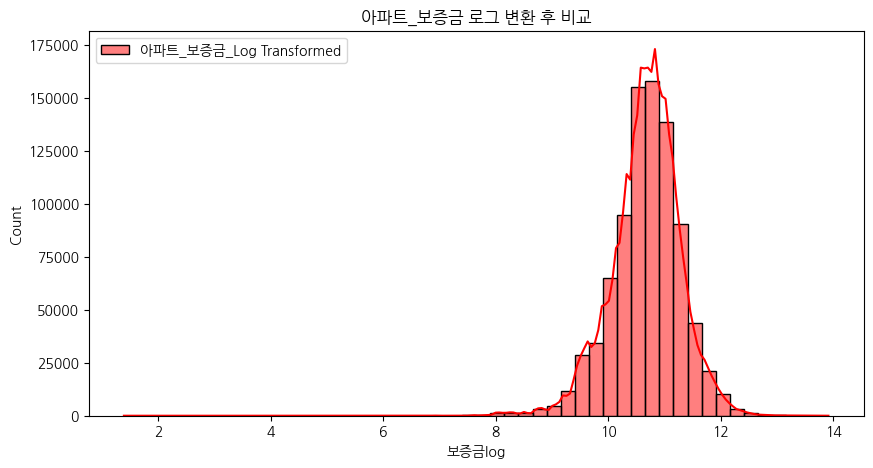

In [149]:
plt.figure(figsize=(10,5))
# sns.histplot(lease_df['단지별_평균_보증금'], bins=50, kde=True, color='blue', label='Original')
# office 데이터만 선택해서 히스토그램 그리기
sns.histplot(
    lease_df.loc[lease_df["주택유형"]=="아파트", '보증금log'],
    bins=50, kde=True, color='red', label='아파트_보증금_Log Transformed'
)
plt.legend()
plt.title("아파트_보증금 로그 변환 후 비교")
plt.savefig(f"{save_path}_APT_보증금_로그변환.png")
plt.show()


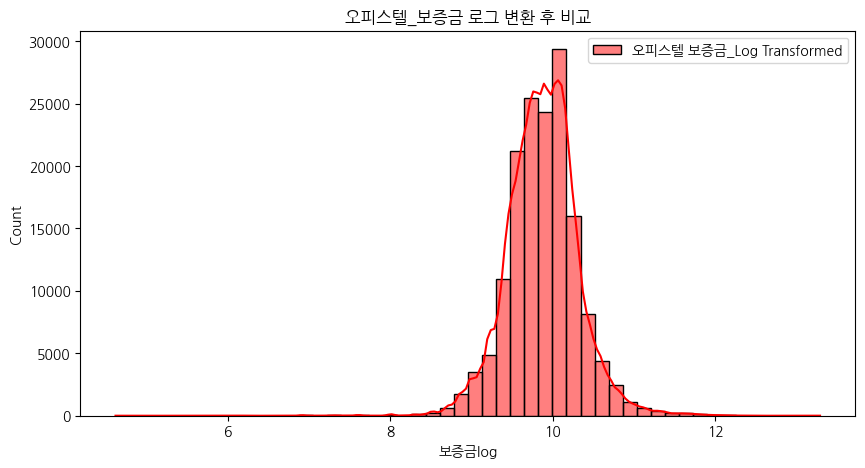

In [150]:
plt.figure(figsize=(10,5))
# sns.histplot(lease_df['단지별_평균_보증금'], bins=50, kde=True, color='blue', label='Original')
# office 데이터만 선택해서 히스토그램 그리기
sns.histplot(
    lease_df.loc[lease_df["주택유형"]=="오피스텔", '보증금log'],
    bins=50, kde=True, color='red', label='오피스텔 보증금_Log Transformed'
)
plt.legend()
plt.title("오피스텔_보증금 로그 변환 후 비교")
plt.savefig(f"{save_path}_OFFICE_보증금_로그변환.png")
plt.show()


#### 컬럼 정렬 및 중복 제거 후 저장
- 계약월 -> 계약분기
- 자료형 변환
        lease_df['건축년도'] = lease_df['건축년도'].astype(int)
        lease_df['주택유형'] = lease_df['주택유형'].astype('category')
        lease_df['계약구분보완'] = lease_df['계약구분보완'].astype('category')
        lease_df['계약분기'] = lease_df['계약분기'].astype('category')

In [151]:
lease_df.columns

Index(['단지명', '전월세구분', '전용면적m', '보증금만원', '층', '건축년도', '갱신요구권사용(2진)',
       '종전계약보증금만원', '주택유형', 'Index', 'Rate', 'PpRate', '전체주소', '계약날짜', '계약연도',
       '계약월', '계약요일', 'IMF경과년수', '금융위기경과년수', '계약개월수', '계약구분보완(범주)',
       'IsNewContract(2진)', 'IsRenewal(2진)', '보증금변화만원', '종전계약유무(2진)',
       'IsRent(2진)', 'Timestamp', '단지별평균보증금만원', '단지갯수', '단지별평균보증금log',
       '보증금log'],
      dtype='object')

In [152]:
lease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024931 entries, 0 to 1024930
Data columns (total 31 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   단지명                1024931 non-null  object        
 1   전월세구분              1024931 non-null  object        
 2   전용면적m              1024931 non-null  float64       
 3   보증금만원              1024931 non-null  float64       
 4   층                  1024931 non-null  int64         
 5   건축년도               1024931 non-null  float64       
 6   갱신요구권사용(2진)        1024931 non-null  int64         
 7   종전계약보증금만원          1024931 non-null  float64       
 8   주택유형               1024931 non-null  object        
 9   Index              1024931 non-null  float64       
 10  Rate               1024931 non-null  float64       
 11  PpRate             1024931 non-null  float64       
 12  전체주소               1024931 non-null  object        
 13  계약날짜               1024931 

In [153]:
# # 계약월을 분기로 변환 (1~3월 → Q1, 4~6월 → Q2, ...)
# lease_df['계약분기'] = ((lease_df['계약월'] - 1) // 3 + 1).astype('category')
# lease_df = lease_df.drop(columns=['계약월'])  # 기존 계약월 컬럼 삭제

# # 건축년도 int형 변환
# lease_df['건축년도'] = lease_df['건축년도'].astype(int)

# # 카테고리형 변환
# category_cols = ['주택유형', '계약구분_보완']
# for col in category_cols:
#     lease_df[col] = lease_df[col].astype('category')

# # 변경 후 데이터 타입 확인
# print(lease_df.dtypes)

In [154]:
lease_df['계약분기'] = ((lease_df['계약월'] - 1) // 3 + 1).astype('category')
# 1. 필요 없는 컬럼 삭제
lease_df = lease_df.drop(columns=['계약월'])  # 기존 계약월 컬럼 삭제
lease_df = lease_df.drop(columns=['계약요일', 'Timestamp', 'IsRent(2진)'])


In [155]:
lease_df.columns

Index(['단지명', '전월세구분', '전용면적m', '보증금만원', '층', '건축년도', '갱신요구권사용(2진)',
       '종전계약보증금만원', '주택유형', 'Index', 'Rate', 'PpRate', '전체주소', '계약날짜', '계약연도',
       'IMF경과년수', '금융위기경과년수', '계약개월수', '계약구분보완(범주)', 'IsNewContract(2진)',
       'IsRenewal(2진)', '보증금변화만원', '종전계약유무(2진)', '단지별평균보증금만원', '단지갯수',
       '단지별평균보증금log', '보증금log', '계약분기'],
      dtype='object')

In [156]:

# 2. 자료형 변환
lease_df['건축년도'] = lease_df['건축년도'].astype(int)
lease_df['주택유형'] = lease_df['주택유형'].astype('category')
lease_df['계약구분보완(범주)'] = lease_df['계약구분보완(범주)'].astype('category')
lease_df['계약분기'] = lease_df['계약분기'].astype('category')


In [157]:
lease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024931 entries, 0 to 1024930
Data columns (total 28 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   단지명                1024931 non-null  object        
 1   전월세구분              1024931 non-null  object        
 2   전용면적m              1024931 non-null  float64       
 3   보증금만원              1024931 non-null  float64       
 4   층                  1024931 non-null  int64         
 5   건축년도               1024931 non-null  int64         
 6   갱신요구권사용(2진)        1024931 non-null  int64         
 7   종전계약보증금만원          1024931 non-null  float64       
 8   주택유형               1024931 non-null  category      
 9   Index              1024931 non-null  float64       
 10  Rate               1024931 non-null  float64       
 11  PpRate             1024931 non-null  float64       
 12  전체주소               1024931 non-null  object        
 13  계약날짜               1024931 

In [159]:
lease_df = lease_df[[
    # ✅ 기본 정보 (객체형, 날짜형, 범주형)
    "단지명", "주택유형", "전체주소", "계약날짜", "계약구분보완(범주)", "계약분기",

    # ✅ 정수형 데이터
    "층", "건축년도", "갱신요구권사용(2진)", "계약연도", "계약개월수",
    "IsNewContract(2진)", "IsRenewal(2진)", "종전계약유무(2진)", "단지갯수",

    # ✅ 실수형 데이터
    "전용면적m", "보증금만원", "종전계약보증금만원", "Index", "Rate", "PpRate",
    "IMF경과년수", "금융위기경과년수", "보증금변화만원",
    "단지별평균보증금만원", "단지별평균보증금log", "보증금log"
]]

In [160]:
lease_df["종전계약유무(2진)"].value_counts()

,count
종전계약유무(2진),
0,836591
1,188340


#### 이상치 제거 하지 않은

In [161]:
## 데이터 포맷 저장
lease_df.to_csv("/content/drive/MyDrive/Colab Notebooks/predict_price/DATA/4_final_lease.csv", index=False, date_format="%Y-%m-%d")



#### 데이터 이상치 탐색
1. 보증금 데이터 log 변환 한 것을 기준으로 IQR - 정규분포에서 사용하기 좋음
    - 구 별
    - 단지 별


In [173]:
lease_df["보증금면적비"] = lease_df["보증금만원"] / lease_df["전용면적m"]


In [175]:
lease_df['보증금면적비'].describe()

,보증금면적비
count,1.024931e+06
mean,6.912801e+02
std,3.025506e+02
min,1.004352e-01
25%,4.830085e+02
50%,6.462585e+02
75%,8.368201e+02
max,4.486764e+03


In [165]:
def iqr_outlier(df, group_col, target_col):
    grouped = df.groupby(group_col)[target_col]
    Q1 = grouped.transform(lambda x: x.quantile(0.25))
    Q3 = grouped.transform(lambda x: x.quantile(0.75))
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df[target_col] < lower_bound) | (df[target_col] > upper_bound)

lease_df["구별이상치"] = iqr_outlier(lease_df, "구", "보증금log")
lease_df["단지별이상치"] = iqr_outlier(lease_df, "단지명", "보증금log")

In [167]:

# 🔹 이상치 개수 확인
print("구 이상치 개수:", lease_df["구이상치"].sum())
print("단지 이상치 개수:", lease_df["단지이상치"].sum())


구 이상치 개수: 17373
단지 이상치 개수: 28661


In [169]:
lease_df["단지갯수"].describe()

,단지갯수
count,1.024931e+06
mean,1.253803e+03
std,1.716932e+03
min,1.000000e+00
25%,2.420000e+02
50%,6.750000e+02
75%,1.549000e+03
max,1.156100e+04


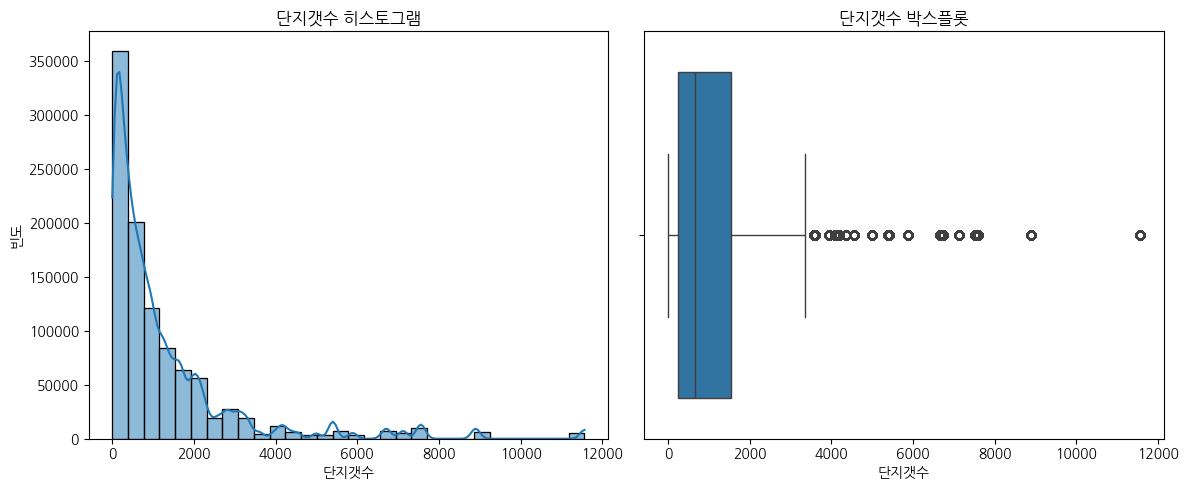

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(lease_df['단지갯수'], bins=30, kde=True)
plt.xlabel('단지갯수')
plt.ylabel('빈도')
plt.title('단지갯수 히스토그램')

# 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x=lease_df['단지갯수'])
plt.xlabel('단지갯수')
plt.title('단지갯수 박스플롯')

plt.tight_layout()
plt.show()


In [1]:
def KDEPlot(df, target1,target2, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.kdeplot(
        x=lease_df[target1],
        y=lease_df[target2],
        fill=True, cmap="Blues", levels=30, alpha=0.5
    )
    sns.scatterplot(x=lease_df[target1], y=lease_df[target2], alpha=0.5, color='red')

    plt.xlabel(f'{target1}')
    plt.ylabel(f'{target2}')
    plt.title(f'{target1} vs {target2}(산점도 + KDE)')
    if save_path:
        plt.savefig(f"{save_path}/{target1}-{target2}.png", dpi=300)
    plt.show()


In [3]:
save_path="/content/drive/MyDrive"
KDEPlot(lease_df, "단지갯수", "단지별평균보증금만원",save_path)

NameError: name 'lease_df' is not defined

In [ ]:
plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=lease_df['단지갯수'],
    y=lease_df['단지별평균보증금log'],
    fill=True, cmap="Blues", levels=30, alpha=0.5
)
sns.scatterplot(x=lease_df['단지갯수'], y=lease_df['단지별평균보증금log'], alpha=0.5, color='red')

plt.xlabel('단지갯수')
plt.ylabel('평균 보증금log')
plt.title('단지갯수 vs 평균 보증금 (산점도 + KDE)')
plt.show()


In [ ]:
lease_df['단지갯수log'] = np.log1p(lease_df['단지갯수'])
plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=lease_df['단지갯수log'],
    y=lease_df['단지별평균보증금만원'],
    fill=True, cmap="Blues", levels=30, alpha=0.5
)
sns.scatterplot(x=lease_df['단지갯수log'], y=lease_df['단지별평균보증금만원'], alpha=0.5, color='red')

plt.xlabel('로그 단지갯수')
plt.ylabel('평균 보증금')
plt.title('로그 단지갯수 vs 평균 보증금 (산점도 + KDE)')
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=lease_df['단지갯수log'],
    y=lease_df['단지별평균보증금log'],
    fill=True, cmap="Blues", levels=30, alpha=0.5
)
sns.scatterplot(x=lease_df['단지갯수log'], y=lease_df['단지별평균보증금log'], alpha=0.5, color='red')

plt.xlabel('로그 단지갯수')
plt.ylabel('평균 보증금')
plt.title('로그 단지갯수 vs 평균 보증금 (산점도 + KDE)')
plt.show()

In [ ]:
lease_df['구']

In [96]:
lease_df['구'].value_counts()

,count
구,
송파구,87488
강서구,85770
강남구,81661
노원구,71064
영등포구,61575
강동구,58148
서초구,56690
양천구,50700
마포구,47240


In [106]:
pd.Series(list(lease_df['구'].value_counts())).describe()

,0
count,25.000000
mean,40997.240000
std,22922.991228
min,8537.000000
25%,24642.000000
50%,34756.000000
75%,56690.000000
max,87488.000000


In [110]:
len(lease_df['동'].unique())

4154

In [107]:
pd.Series(list(lease_df['동'].value_counts())).describe()


,0
count,4154.000000
mean,246.733510
std,711.561301
min,1.000000
25%,10.000000
50%,44.000000
75%,171.000000
max,13172.000000


In [108]:
pd.Series(list(lease_df['단지명'].value_counts())).describe()

,0
count,10987.000000
mean,93.285792
std,259.822749
min,1.000000
25%,5.000000
50%,17.000000
75%,70.000000
max,6524.000000


#### 데이터 저장

In [119]:
lease_df.loc[(lease_df['구_이상치'] == 1)& (lease_df['단지_이상치']),"단지갯수"]

,단지갯수
605,665
1250,425
1262,403
1422,4992
1423,4992
...,...
1019986,63
1021128,123
1022294,78
1024131,66


In [ ]:
## 로드시 참고
# df = pd.read_csv("data.csv",
#                  parse_dates=["계약날짜"],  # 날짜 컬럼 복구
#                  dtype={                  # category 컬럼 복구
#                      "주택유형": "category",
#                      "계약구분보완(범주)": "category",
#                      "계약분기": "category"
#                  })
